# Random Warmup

In this notebook, we explore the results generated by the `randomwarmup.sh` script, where we reduce the number of total episodes from 50k (see `bruteforce.ipynb`) to 20k and make the agents start with a random policy 10k _steps_ before their actual training starts.
This way, their can fill up their buffer(s) with random (i.e., not biased) experiences before they start learning from them.

The idea is that this should help the agents overcome the initial bias they seem to be suffering from in the first $\pm$ 20k episodes.
If we see any improvements to their rewards and/or action biases, we can infer that using a random warmup is a good idea.

The configurations that we explore are largely similar to the brute force experiments.
The only difference being that for the agents using TN, the target network update frequency is reduced from 2.5k to 1k.
This way, the target network is now updated just as many times as in the brute force experiments.

The other settings are also pretty much the same, but with these adjustments:
  - number of individual runs: 6 $\to$ 5
  - number of episodes: 50k $\to$ 20k
  - number of random warmup steps: 0 $\to$ 10k

## Preliminaries

In [69]:
import os

from dql.utils.namespaces import P
from dql.utils.datamanager import ConcatDataManager
from dql.utils.plotter import ColorPlot, LossPlot

import numpy as np
import matplotlib.pyplot as plt

Check if we have the data.

Should be BL, ER, TN, and TR.

In [70]:
expID = 'RW'
expName = 'Random Warmup'
runIDs = [f for f in os.listdir(P.data) if f.startswith(expID + '-')]
print('\n'.join(runIDs))

RW-TR
RW-TN
RW-ER
RW-BL


Check if the parameters are correct.
We check for the run using the `TR` config, since it will contain all the hyperparameters.

In [71]:
ConcatDataManager(f'{expID}-TR').printSummary()

meta:
	runID: RW-TR
	numRepetitions: 5
	numEpisodes: 10000
	runs: 5
params:
	explorationStrategy: egreedy
	annealingScheme:
		id: 1
		startVal: 1.0
		endVal: 0.01
		window: 0.8
		kind: exponential
	experienceReplay: True
	targetNetwork: True
	replayBufferSize: 100000
	targetFrequency: 1000
	alpha: 0.0010
	gamma: 0.9990
	batchSize: 512
results:
	avgRuntime: 06:15.522 min
	avgReward: 20.0880
	avgActionBias: 0.7363
	avgLoss: 0.4015


## Plotting

Define a function to easily get all figures for a given run.

In [72]:
runNames = {'BL': 'Baseline', 'ER': 'Experience Replay', 'TN': 'Target Network', 'TR': 'Target Network + Experience Replay'}

def getFigs(runID: str) -> tuple[plt.Figure]:
    title = f'{runNames[runID]}\n{expName}'
    DM = ConcatDataManager(f'{expID}-{runID}')

    R = DM.loadRewards()
    fR = ColorPlot(R, label='reward', title=title).getFig()

    A = DM.loadActions()
    AB = np.abs((A / np.sum(A, axis=2, keepdims=True))[:, :, 0] - .5) * 2
    fAB = ColorPlot(AB, label='action bias', title=title).getFig()

    L = DM.loadLosses()
    fL = LossPlot(L, title=title).getFig()
    return fR, fAB, fL

---
### Baseline

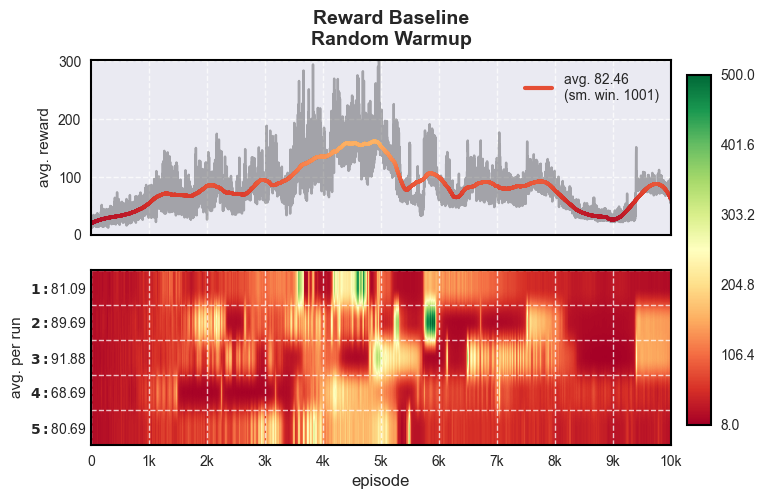

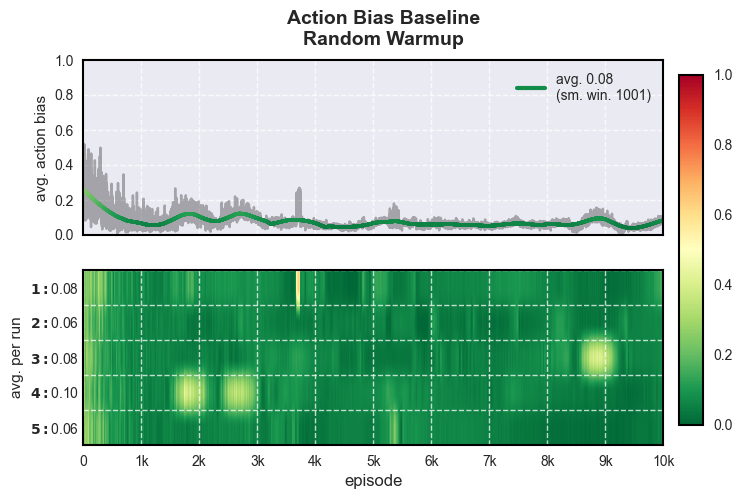

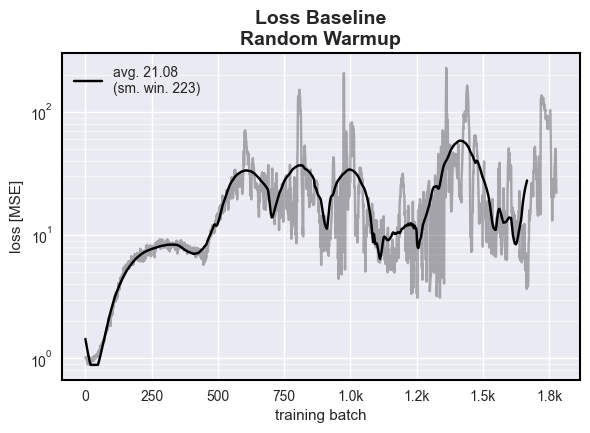

In [73]:
runID = 'BL'
rewardFig, actionBiasFig, lossFig = getFigs(runID)

---
### Experience Replay

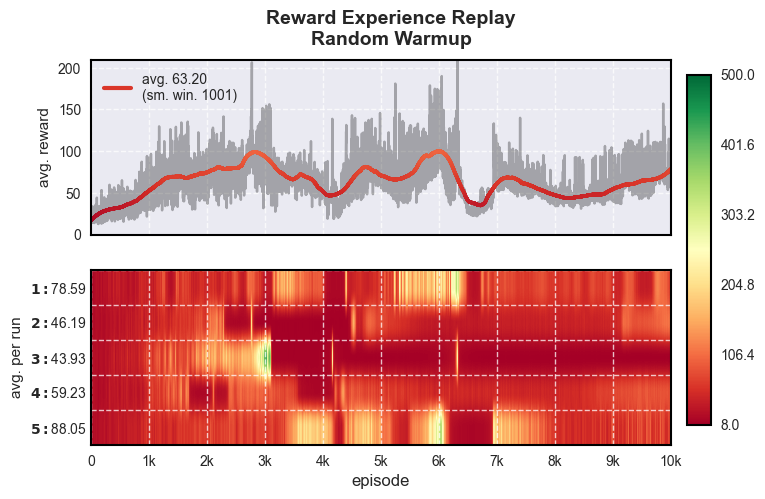

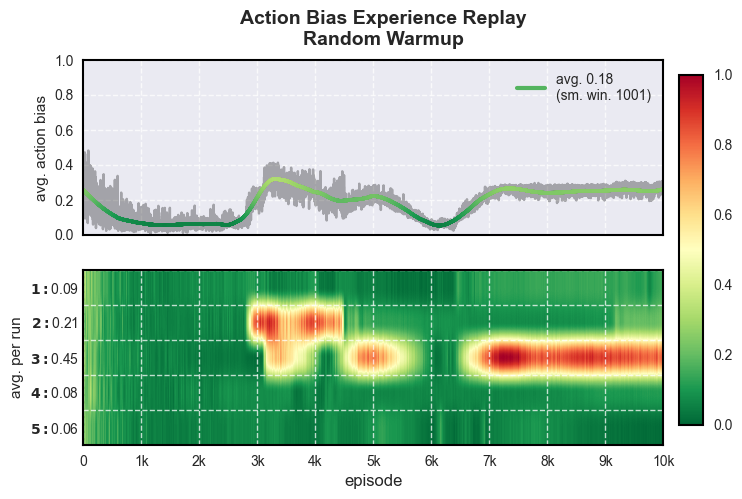

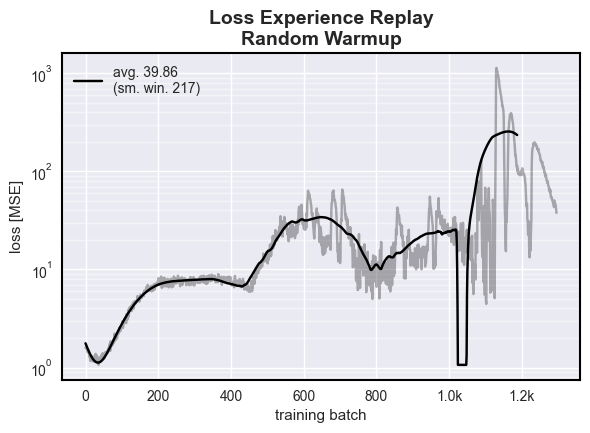

In [74]:
runID = 'ER'
rewardFig, actionBiasFig, lossFig = getFigs(runID)

---
### Target Network

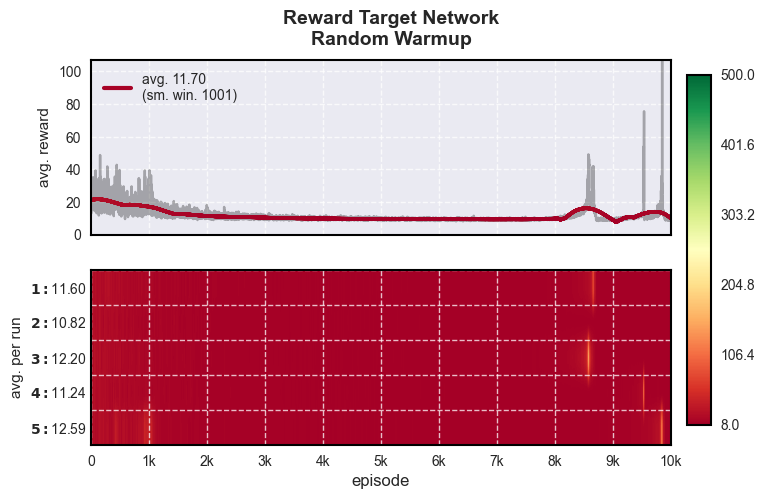

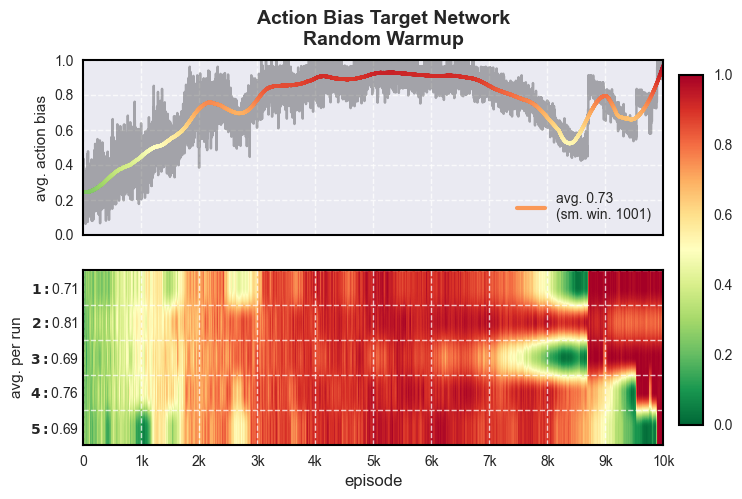

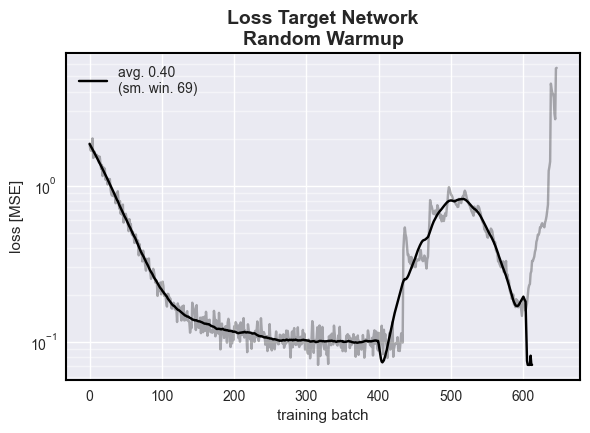

In [75]:
runID = 'TN'
rewardFig, actionBiasFig, lossFig = getFigs(runID)

---
### Target Network + Experience Replay

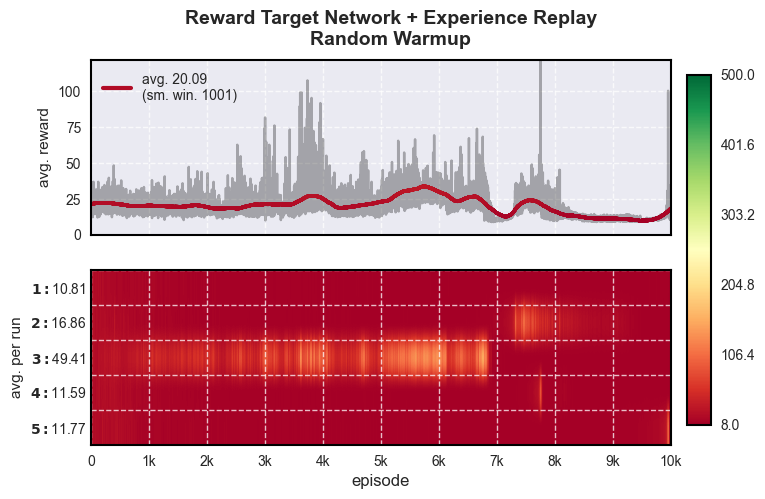

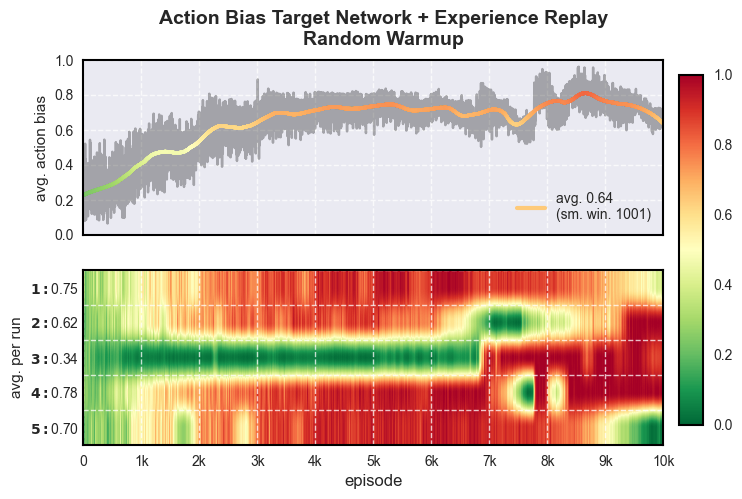

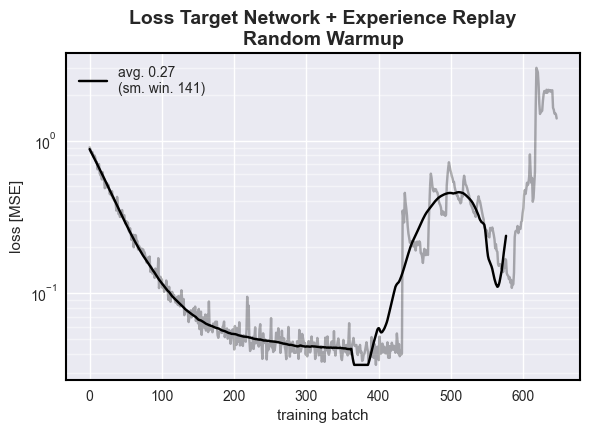

In [76]:
runID = 'TR'
rewardFig, actionBiasFig, lossFig = getFigs(runID)

---
### Comparison [POC]

In [84]:
from scipy.signal import savgol_filter

# redefine runIDs to get correct order
runIDs = ['RW-BL', 'RW-ER', 'RW-TN', 'RW-TR']

database = {'reward': {}, 'action bias': {}}
for runID in runIDs:
    DM = ConcatDataManager(runID)
    R = DM.loadRewards()
    database['reward'][runID] = R
    A = DM.loadActions()
    AB = np.abs((A / np.sum(A, axis=2, keepdims=True))[:, :, 0] - .5) * 2
    database['action bias'][runID] = AB

In [85]:
for arrName, runs in database.items():
    print(arrName)
    for runID, arr in runs.items():
        print(f'\t{runID}: {arr.shape}')

reward
	RW-BL: (5, 10000)
	RW-ER: (5, 10000)
	RW-TN: (5, 10000)
	RW-TR: (5, 10000)
action bias
	RW-BL: (5, 10000)
	RW-ER: (5, 10000)
	RW-TN: (5, 10000)
	RW-TR: (5, 10000)


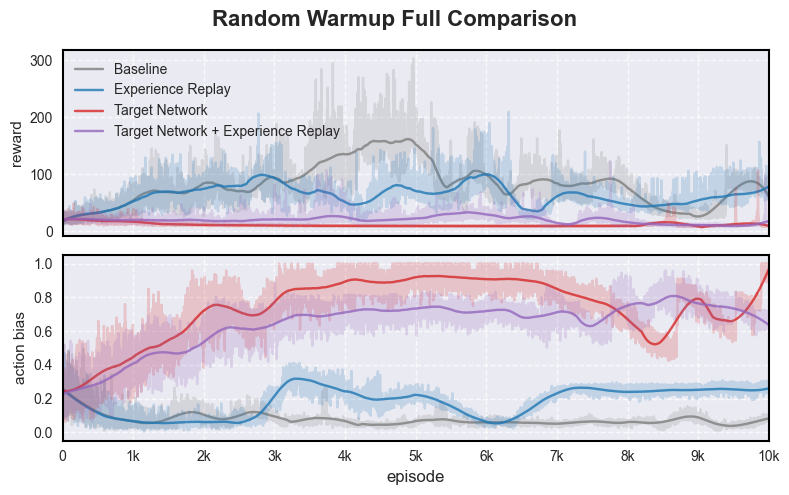

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
colors = {'BL': 'tab:gray', 'ER': 'tab:blue', 'TN': 'tab:red', 'TR': 'tab:purple'}
nEps = database['reward']['RW-BL'].shape[1]
smWin = nEps // 10 + 1

for ax, (arrName, runDict) in zip([ax1, ax2], database.items()):
    for runID, arr in runDict.items():
        short = runID[3:]
        avg = np.mean(arr, axis=0)
        ax.plot(avg, color=colors[short], alpha=.2)
        smoothed = savgol_filter(avg, smWin, 3)
        ax.plot(smoothed, color=colors[short], alpha=.8, label=runNames[short])
    ax.set_ylabel(arrName)
    ax.grid(color='w', linestyle='--', linewidth=1, alpha=.75)
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
        spine.set_linewidth(1.5)

ax1.legend(loc='upper left')
ax2.set_xlabel('episode', fontsize=12)
ax2.set_xticks(np.linspace(0, nEps, 11))
ax2.xaxis.set_major_formatter(lambda x, _: f'{x / 1000:.0f}k' if x >= 1000 else f'{x:.0f}')
ax2.set_xlim(0, nEps)
ax2.set_ylim(-.05, 1.05)

fig.suptitle(f'{expName} Full Comparison', fontsize=16, weight='bold')
fig.tight_layout();